<a href="https://colab.research.google.com/github/seeverblog/RD_LEVEL_CLASSIFICATION/blob/master/RESNET_50_augmented_zoom_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [33]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
files = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/APTOS/AUGMENTED/*')

len (files)

7806

In [34]:
train_imgs = [fn for fn in files]
len(train_imgs)

7806

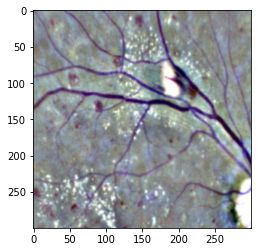

In [35]:
import matplotlib.image as mpimg
for ima in train_imgs[0:1]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

In [0]:
nrows = 312
ncolumns = 312
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
X, y = read_and_process_image(train_imgs)

Text(0.5, 1.0, 'Total images of each class')

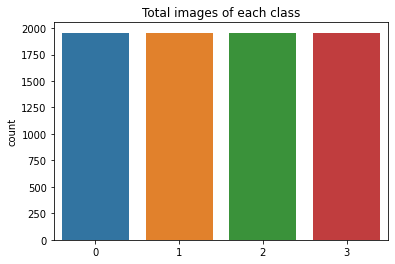

In [38]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Total images of each class')

In [39]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (7806, 312, 312, 3)
Shape of labels is: (7806,)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=np.array(y),random_state=2)

In [41]:
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (6244, 312, 312, 3)
Shape of validation images is: (1562, 312, 312, 3)
Shape of labels is: (6244,)
Shape of labels is: (1562,)


In [0]:
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [43]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)

y_train_ohe.shape,y_val_ohe.shape

((6244, 4), (1562, 4))

In [0]:
BATCH_SIZE = 32
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 312
WIDTH = 312
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [0]:
IMG_SHAPE = (312, 312, 3)
base_model =tf.keras.applications.ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x =tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x =tf.keras.layers.Dropout(0.5)(x)
x =tf.keras.layers.Dense(2048, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
final_output =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x)
model =tf.keras.models.Model(inputs=base_model.inputs,outputs=final_output)

In [0]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True


In [0]:
metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [0]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                 zoom_range=[0.9, 1.1],
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = train_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)

In [50]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=WARMUP_EPOCHS,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/2
 48/195 [======>.......................] - ETA: 1:37 - loss: 2.1528 - accuracy: 0.3197

KeyboardInterrupt: ignored

In [0]:
for layer in model.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [0]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [0]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history